In [1]:
import numpy as np
import pandas as pd
import math
import os
import datetime

from sklearn.svm import SVR
from DP_LSTM import *
from keras.models import load_model
from pandas.tools.plotting import autocorrelation_plot
from sklearn.preprocessing import MinMaxScaler
from Plot_Self_Correlation import plot_auto_corr

from matplotlib import pyplot as plt

Using TensorFlow backend.


In [2]:
def walkfiles(rootdir): # 返回file路径的list
    flist = os.listdir(rootdir) #列出文件夹下所有的目录与文件
    pathContainer = []
    filenameContainer = []
    for i in range(0,len(flist)):
        path = os.path.join(rootdir,flist[i])
        if os.path.isfile(path):
            pathContainer.append(path)
            filenameContainer.append(flist[i])
    return pathContainer,filenameContainer

In [3]:
#首先对一种货币进行短期预测实验
# 第i个文件
'''
['D:\\WORK__wells\\GraduateProgram\\Data\\DailyData\\AUDUSD.csv',
 'D:\\WORK__wells\\GraduateProgram\\Data\\DailyData\\EURUSD.csv',
 'D:\\WORK__wells\\GraduateProgram\\Data\\DailyData\\GBPUSD.csv',
 'D:\\WORK__wells\\GraduateProgram\\Data\\DailyData\\USDCAD.csv',
 'D:\\WORK__wells\\GraduateProgram\\Data\\DailyData\\USDCHF.csv',
 'D:\\WORK__wells\\GraduateProgram\\Data\\DailyData\\USDCNY.csv',
 'D:\\WORK__wells\\GraduateProgram\\Data\\DailyData\\USDJPY.csv',
'''
# 根据序号获取数据,name
def get_data(i,pathContainer, filenameContainer):
    ExgRate_pd = pd.read_csv(pathContainer[i])
    ExgRate_pd['DateTime'] = pd.to_datetime(ExgRate_pd.Date)
    ExgRate_pd['ExgRate'] = ExgRate_pd.close
    ExgRate_pd.drop(['Date','open','high','low','close'],axis=1,inplace=True)
    ExgRate_pd = ExgRate_pd.loc[ExgRate_pd.DateTime>'2009']
    ExgRate_pd.index = [i for i in range(ExgRate_pd.shape[0])]
    return ExgRate_pd,filenameContainer[i].split('.')[0]

In [4]:
# 划分预训练数据与测试数据
def data_split(ExgRate_pd):
    preTrained_pd = ExgRate_pd.loc[ExgRate_pd.DateTime < '2015']
    preTrained_pd.index = [i for i in range(preTrained_pd.shape[0])]
    data_pd = ExgRate_pd.loc[ExgRate_pd.DateTime > '2015']
    data_pd.index = [i for i in range(data_pd.shape[0])]
    return preTrained_pd,data_pd

In [5]:
'''数据处理模块'''
#对实验数据进行归一化处理
def GetTimeScale(data_pd, Time_scale):#根据给定的时间宽度构造数据
    result_dic = {'DateTime':[],'ExgRate':[]}
    for i in range(data_pd.shape[0]):
        if (i+1)%Time_scale == 0:
            new_grid_pd = data_pd.iloc[i,:]
            result_dic['DateTime'].append(new_grid_pd.DateTime)
            result_dic['ExgRate'].append(new_grid_pd.ExgRate)
    result_pd = pd.DataFrame(result_dic)
    return result_pd

def Raw_Data_Normalized(Raw_df): # 标准化数据
    Raw_pd = Raw_df.copy()
    MMScaler = MinMaxScaler(feature_range=(0.1,1))
    MMScaled_Data = MMScaler.fit_transform(np.reshape(Raw_pd['ExgRate'].get_values(),(Raw_pd.ExgRate.shape[0],1)))
    Raw_pd['ExgRate'] = MMScaled_Data
    return Raw_pd,MMScaler

def GetTimeSeriesData(Normalized_pd, TimeLag): #根据时滞创建时间序列数据
    # 输入 标准化后的完整数据、时滞TimeLag
    # 输出 时间序列数据 np.array
    sequence_length = TimeLag + 1
    result = []
    for index in range(len(Normalized_pd) - sequence_length):
        result.append(Normalized_pd.ExgRate[index: index + sequence_length])
    result = np.array(result)
    return result

In [6]:
'''
迁移学习主要模块：基模型的预训练、FineTune
'''
def PrePareLSTM(ExgRate_pd,params):
    print(r'预训练模型')
    Base_pd = ExgRate_pd.copy()
    Base_pd,BaseMMScaler = Raw_Data_Normalized(Base_pd)
    TimeSeries = GetTimeSeriesData(Base_pd, params['TimeLag'])
    PretrainSeries_X = TimeSeries[:,:-1]
    PretrainSeries_Y = TimeSeries[:,-1]
    # 张量化
    PretrainSeries_X = np.reshape(PretrainSeries_X, (PretrainSeries_X.shape[0], 1,PretrainSeries_X.shape[1]))
    PretrainSeries_Y = np.reshape(PretrainSeries_Y, (PretrainSeries_Y.shape[0], 1,1))
    #预先训练基本模型
    pre_Model = build_LSTM_Model(inputDim = PretrainSeries_X.shape[2],lr=params['lr'],
                                 nb_hidden_cell=params['nb_hidden_cell'])
    Fitted_pre_model = model_fit(pre_Model,PretrainSeries_X, PretrainSeries_Y, 
                                 validation_split=0.2, epochs=params['epochs'], 
                                 batch_size=params['batch_size'])
    print(r'预训练模型学习完毕！') 
    return Fitted_pre_model

def FineTune(Prepared_model, Train_X, Train_Y,params):
    from keras.layers import Dense
    model_new = Prepared_model
    model_new.pop()
    for i in range(len(Prepared_model.layers)-1):  # 除最后一层外，权重全部导入
        model_new.layers[i].set_weights(Prepared_model.layers[i].get_weights())
        if i < params['frozenlayer']:
            model_new.layers[i].trainable=False
    
        # model_new.add(Dense(5, activation='sigmoid', name='last2'))
    model_new.add(Dense(1,use_bias = True,activation='linear'))
#     saveFile = 'D:/CPQ/air/hour_tranfer_hour'
    #调整迁移预测数据准备
    # 标准化进行预测
    print('微调迁移学习模型')
    Prepared_model = model_fit(model_new, Train_X, 
                                   Train_Y,epochs=params['TransferEpochs'], 
                                   batch_size=params['TransferBatch_size'])
    return Prepared_model

In [7]:
'''
已知时间越长，LSTM预测的效果越差，那么接下来看是否迁移学习对预测效果有没有提升


'''
'''
输入：DataFrame， 参数params
输出： 与BP神经网络、支持向量回归和时间序列模型进行比较得到的各项指标与预测的值DateFrame
'''


def TransferLearning(data_pd, PrepareModel,params,fileName, fileName2):
    
    #定义存储结果的pd
    result_pd = pd.DataFrame(columns=['Timescale','RMSE','MAE','MAPE',
                                      'T-RMSE','T-MAE','T-MAPE'])
    line_pd = pd.DataFrame(columns=['Timescale','RMSE','MAE','MAPE',
                                    'T-RMSE','T-MAE','T-MAPE'])
    # 对数据进行预处理
    for eachTimeScale in params['Timescale']:   
        print(r'时间粒度',eachTimeScale)
        scaleddata_pd = GetTimeScale(data_pd, eachTimeScale)
    
        Raw_pd,MMScaler = Raw_Data_Normalized(scaleddata_pd)
        print(r'处理数据:',Raw_pd.shape)
        # 构造时间序列数据
        TimeSeries = GetTimeSeriesData(Raw_pd, params['TimeLag'])
        # 划分训练测试集
        TrainSeries = TimeSeries[:round(params['TrainTestSplit']*TimeSeries.shape[0]),:]
        print(r'训练数据:',TrainSeries.shape)
        TestSeries = TimeSeries[round(params['TrainTestSplit']*TimeSeries.shape[0]):,:]
        print(r'验证数据:',TestSeries.shape)
        TrainSeries_X = TrainSeries[:,:-1]
        TrainSeries_Y = TrainSeries[:,-1]
        TestSeries_X = TestSeries[:,:-1]
        TestSeries_Y = TestSeries[:,-1]
        # 张量化
        Train_X = np.reshape(TrainSeries_X, (TrainSeries_X.shape[0], 1,TrainSeries_X.shape[1]))
        Train_Y = np.reshape(TrainSeries_Y, (TrainSeries_Y.shape[0], 1,1))
        Test_X = np.reshape(TestSeries_X, (TestSeries_X.shape[0], 1,TestSeries_X.shape[1]))
        Test_Y = np.reshape(TestSeries_Y, (TestSeries_Y.shape[0], 1,1))
        print(r'LSTM预测')
    
        LSTM_Model = build_LSTM_Model(inputDim = Train_X.shape[2],lr=params['lr'],nb_hidden_cell=params['nb_hidden_cell'])
        Fitted_model = model_fit(LSTM_Model,Train_X, Train_Y, validation_split=0.2, epochs=params['epochs'], batch_size=params['batch_size'])
        RMSE,MAE,MAPE,Predict_y,True_Y = model_predict(Fitted_model,Test_X,Test_Y,MMScaler)
        line_pd['RMSE'] = [RMSE]
        line_pd['MAE'] = [MAE]
        line_pd['MAPE'] = [MAPE]
        line_pd['Timescale'] = [eachTimeScale]
    
        print(r'迁移学习微调')
        finetunned_model = FineTune(PrepareModel, Train_X, Train_Y,params)
        print(r'迁移学习LSTM预测')
        RMSE,MAE,MAPE,Predict_y,True_Y = model_predict(finetunned_model,Test_X,Test_Y,MMScaler)
        line_pd['T-RMSE'] = [RMSE]
        line_pd['T-MAE'] = [MAE]
        line_pd['T-MAPE'] = [MAPE]
        result_pd = pd.concat([result_pd, line_pd])
    result_pd.to_csv(r'D:\WORK__wells\GraduateProgram\Result\Transfer_Result_'+ fileName +'_to_'+ fileName2+'.csv',index=None)
    result_pd.index = [i for i in range(result_pd.shape[0])]
    return result_pd

In [8]:
rootdir = r'D:\WORK__wells\GraduateProgram\Data\DailyData'
pathContainer,filenameContainer = walkfiles(rootdir)
# print(pathContainer)

fileIndex = [0,1]
# 0为澳元 1为欧元 5为CNY

# ExgRate_pd ,fileName= get_data(0,pathContainer,filenameContainer) # 澳元
ExgRate_pd ,fileName= get_data(5,pathContainer,filenameContainer) # 人民币

ExgRate2_pd ,fileName2= get_data(1,pathContainer,filenameContainer) # 欧元

preTrained_pd,data_pd = data_split(ExgRate_pd)

In [9]:
params = {
          'Timescale':[7],
          'lr': 0.0001,
          'nb_hidden_cell': [80,80,80,80,80,80],
          'epochs': 500,
          'batch_size': 50,
          'TimeLag': 10,
          'TrainTestSplit':0.7,
          
          'TransferEpochs':50,
          'TransferBatch_size':10,
          'frozenlayer':3,
        }

预训练模型
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 1156 samples, validate on 289 samples
Epoch 1/500
1156/1156 [==============================] - 8s 7ms/step - loss: 0.4807 - mean_absolute_error: 0.6284 - mean_absolute_percentage_error: 98.8382 - val_loss: 0.0504 - val_mean_absolute_error: 0.2138 - val_mean_absolute_percentage_error: 95.6251
Epoch 2/500
1156/1156 [==============================] - 1s 459us/step - loss: 0.4694 - mean_absolute_error: 0.6191 - mean_absolute_percentage_error: 96.8270 - val_loss: 0.0461 - val_mean_absolute_error: 0.2036 - val_mean_absolute_percentage_error: 90.5307
Epoch 3/500
1156/1156 [==============================] - 1s 475us/step - loss: 0.4558 - mean_absolute_error: 0.6077 - mean_absolute_percentage_error: 94.3252 - val_loss: 0.0410 - val_mean_absolute_error: 0.1907 - val_mean_absolute_percentage_error: 84.0828
Epoch 4/500
1156/1156 [==============================] - 0

Epoch 62/500
1156/1156 [==============================] - 0s 346us/step - loss: 0.0020 - mean_absolute_error: 0.0367 - mean_absolute_percentage_error: 9.2071 - val_loss: 0.0053 - val_mean_absolute_error: 0.0641 - val_mean_absolute_percentage_error: 37.8462
Epoch 63/500
1156/1156 [==============================] - 0s 344us/step - loss: 0.0019 - mean_absolute_error: 0.0365 - mean_absolute_percentage_error: 9.1677 - val_loss: 0.0052 - val_mean_absolute_error: 0.0637 - val_mean_absolute_percentage_error: 37.6558
Epoch 64/500
1156/1156 [==============================] - 0s 347us/step - loss: 0.0019 - mean_absolute_error: 0.0364 - mean_absolute_percentage_error: 9.1279 - val_loss: 0.0052 - val_mean_absolute_error: 0.0634 - val_mean_absolute_percentage_error: 37.4647
Epoch 65/500
1156/1156 [==============================] - 0s 347us/step - loss: 0.0019 - mean_absolute_error: 0.0362 - mean_absolute_percentage_error: 9.0878 - val_loss: 0.0051 - val_mean_absolute_error: 0.0631 - val_mean_absolut

Epoch 94/500
1156/1156 [==============================] - 1s 439us/step - loss: 0.0014 - mean_absolute_error: 0.0313 - mean_absolute_percentage_error: 7.7883 - val_loss: 0.0037 - val_mean_absolute_error: 0.0527 - val_mean_absolute_percentage_error: 31.3547
Epoch 95/500
1156/1156 [==============================] - 1s 433us/step - loss: 0.0014 - mean_absolute_error: 0.0311 - mean_absolute_percentage_error: 7.7393 - val_loss: 0.0036 - val_mean_absolute_error: 0.0523 - val_mean_absolute_percentage_error: 31.1411
Epoch 96/500
1156/1156 [==============================] - 1s 465us/step - loss: 0.0014 - mean_absolute_error: 0.0309 - mean_absolute_percentage_error: 7.6902 - val_loss: 0.0036 - val_mean_absolute_error: 0.0519 - val_mean_absolute_percentage_error: 30.9266
Epoch 97/500
1156/1156 [==============================] - 0s 422us/step - loss: 0.0014 - mean_absolute_error: 0.0307 - mean_absolute_percentage_error: 7.6408 - val_loss: 0.0035 - val_mean_absolute_error: 0.0516 - val_mean_absolut

Epoch 126/500
1156/1156 [==============================] - 1s 695us/step - loss: 8.7589e-04 - mean_absolute_error: 0.0247 - mean_absolute_percentage_error: 6.1185 - val_loss: 0.0022 - val_mean_absolute_error: 0.0404 - val_mean_absolute_percentage_error: 24.2125
Epoch 127/500
1156/1156 [==============================] - 0s 409us/step - loss: 8.6058e-04 - mean_absolute_error: 0.0244 - mean_absolute_percentage_error: 6.0631 - val_loss: 0.0022 - val_mean_absolute_error: 0.0400 - val_mean_absolute_percentage_error: 23.9814
Epoch 128/500
1156/1156 [==============================] - 1s 542us/step - loss: 8.4538e-04 - mean_absolute_error: 0.0242 - mean_absolute_percentage_error: 6.0077 - val_loss: 0.0022 - val_mean_absolute_error: 0.0396 - val_mean_absolute_percentage_error: 23.7503
Epoch 129/500
1156/1156 [==============================] - 1s 568us/step - loss: 8.3029e-04 - mean_absolute_error: 0.0240 - mean_absolute_percentage_error: 5.9521 - val_loss: 0.0021 - val_mean_absolute_error: 0.039

Epoch 188/500
1156/1156 [==============================] - 0s 385us/step - loss: 2.3199e-04 - mean_absolute_error: 0.0112 - mean_absolute_percentage_error: 2.8019 - val_loss: 5.5555e-04 - val_mean_absolute_error: 0.0200 - val_mean_absolute_percentage_error: 11.4026
Epoch 189/500
1156/1156 [==============================] - 0s 373us/step - loss: 2.2836e-04 - mean_absolute_error: 0.0110 - mean_absolute_percentage_error: 2.7622 - val_loss: 5.4411e-04 - val_mean_absolute_error: 0.0197 - val_mean_absolute_percentage_error: 11.2497
Epoch 190/500
1156/1156 [==============================] - 0s 354us/step - loss: 2.2513e-04 - mean_absolute_error: 0.0108 - mean_absolute_percentage_error: 2.7248 - val_loss: 5.3326e-04 - val_mean_absolute_error: 0.0195 - val_mean_absolute_percentage_error: 11.1024
Epoch 191/500
1156/1156 [==============================] - 0s 357us/step - loss: 2.2221e-04 - mean_absolute_error: 0.0107 - mean_absolute_percentage_error: 2.6886 - val_loss: 5.2294e-04 - val_mean_absol

Epoch 249/500
1156/1156 [==============================] - 1s 472us/step - loss: 3.3603e-04 - mean_absolute_error: 0.0139 - mean_absolute_percentage_error: 2.6394 - val_loss: 3.7940e-04 - val_mean_absolute_error: 0.0154 - val_mean_absolute_percentage_error: 7.9207
Epoch 250/500
1156/1156 [==============================] - 1s 472us/step - loss: 3.3578e-04 - mean_absolute_error: 0.0139 - mean_absolute_percentage_error: 2.6370 - val_loss: 3.7896e-04 - val_mean_absolute_error: 0.0154 - val_mean_absolute_percentage_error: 7.9089
Epoch 251/500
1156/1156 [==============================] - 1s 543us/step - loss: 3.3555e-04 - mean_absolute_error: 0.0139 - mean_absolute_percentage_error: 2.6346 - val_loss: 3.7853e-04 - val_mean_absolute_error: 0.0153 - val_mean_absolute_percentage_error: 7.8974
Epoch 252/500
1156/1156 [==============================] - 1s 558us/step - loss: 3.3534e-04 - mean_absolute_error: 0.0139 - mean_absolute_percentage_error: 2.6324 - val_loss: 3.7810e-04 - val_mean_absolute

Epoch 280/500
1156/1156 [==============================] - 0s 332us/step - loss: 3.3006e-04 - mean_absolute_error: 0.0138 - mean_absolute_percentage_error: 2.5781 - val_loss: 3.6867e-04 - val_mean_absolute_error: 0.0150 - val_mean_absolute_percentage_error: 7.6328
Epoch 281/500
1156/1156 [==============================] - 1s 605us/step - loss: 3.2994e-04 - mean_absolute_error: 0.0138 - mean_absolute_percentage_error: 2.5766 - val_loss: 3.6838e-04 - val_mean_absolute_error: 0.0150 - val_mean_absolute_percentage_error: 7.6253
Epoch 282/500
1156/1156 [==============================] - 0s 380us/step - loss: 3.2981e-04 - mean_absolute_error: 0.0137 - mean_absolute_percentage_error: 2.5750 - val_loss: 3.6808e-04 - val_mean_absolute_error: 0.0150 - val_mean_absolute_percentage_error: 7.6179
Epoch 283/500
1156/1156 [==============================] - 1s 564us/step - loss: 3.2967e-04 - mean_absolute_error: 0.0137 - mean_absolute_percentage_error: 2.5734 - val_loss: 3.6778e-04 - val_mean_absolute

Epoch 311/500
1156/1156 [==============================] - 0s 422us/step - loss: 3.2346e-04 - mean_absolute_error: 0.0136 - mean_absolute_percentage_error: 2.5252 - val_loss: 3.6064e-04 - val_mean_absolute_error: 0.0147 - val_mean_absolute_percentage_error: 7.4344
Epoch 312/500
1156/1156 [==============================] - 0s 380us/step - loss: 3.2333e-04 - mean_absolute_error: 0.0136 - mean_absolute_percentage_error: 2.5238 - val_loss: 3.6044e-04 - val_mean_absolute_error: 0.0147 - val_mean_absolute_percentage_error: 7.4289
Epoch 313/500
1156/1156 [==============================] - 0s 335us/step - loss: 3.2308e-04 - mean_absolute_error: 0.0136 - mean_absolute_percentage_error: 2.5222 - val_loss: 3.6022e-04 - val_mean_absolute_error: 0.0147 - val_mean_absolute_percentage_error: 7.4236
Epoch 314/500
1156/1156 [==============================] - 0s 331us/step - loss: 3.2286e-04 - mean_absolute_error: 0.0136 - mean_absolute_percentage_error: 2.5205 - val_loss: 3.6002e-04 - val_mean_absolute

Epoch 342/500
1156/1156 [==============================] - 0s 321us/step - loss: 3.1552e-04 - mean_absolute_error: 0.0134 - mean_absolute_percentage_error: 2.4724 - val_loss: 3.5352e-04 - val_mean_absolute_error: 0.0145 - val_mean_absolute_percentage_error: 7.2770
Epoch 343/500
1156/1156 [==============================] - 0s 406us/step - loss: 3.1536e-04 - mean_absolute_error: 0.0134 - mean_absolute_percentage_error: 2.4709 - val_loss: 3.5339e-04 - val_mean_absolute_error: 0.0145 - val_mean_absolute_percentage_error: 7.2720
Epoch 344/500
1156/1156 [==============================] - 0s 368us/step - loss: 3.1516e-04 - mean_absolute_error: 0.0134 - mean_absolute_percentage_error: 2.4695 - val_loss: 3.5317e-04 - val_mean_absolute_error: 0.0145 - val_mean_absolute_percentage_error: 7.2678
Epoch 345/500
1156/1156 [==============================] - 0s 414us/step - loss: 3.1495e-04 - mean_absolute_error: 0.0134 - mean_absolute_percentage_error: 2.4679 - val_loss: 3.5296e-04 - val_mean_absolute

Epoch 373/500
1156/1156 [==============================] - 1s 480us/step - loss: 3.0721e-04 - mean_absolute_error: 0.0132 - mean_absolute_percentage_error: 2.4197 - val_loss: 3.4740e-04 - val_mean_absolute_error: 0.0143 - val_mean_absolute_percentage_error: 7.1409
Epoch 374/500
1156/1156 [==============================] - 1s 446us/step - loss: 3.0685e-04 - mean_absolute_error: 0.0132 - mean_absolute_percentage_error: 2.4177 - val_loss: 3.4717e-04 - val_mean_absolute_error: 0.0143 - val_mean_absolute_percentage_error: 7.1366
Epoch 375/500
1156/1156 [==============================] - 1s 545us/step - loss: 3.0647e-04 - mean_absolute_error: 0.0131 - mean_absolute_percentage_error: 2.4157 - val_loss: 3.4692e-04 - val_mean_absolute_error: 0.0143 - val_mean_absolute_percentage_error: 7.1323
Epoch 376/500
1156/1156 [==============================] - 1s 551us/step - loss: 3.0610e-04 - mean_absolute_error: 0.0131 - mean_absolute_percentage_error: 2.4138 - val_loss: 3.4668e-04 - val_mean_absolute

Epoch 404/500
1156/1156 [==============================] - 0s 396us/step - loss: 2.9822e-04 - mean_absolute_error: 0.0129 - mean_absolute_percentage_error: 2.3643 - val_loss: 3.4032e-04 - val_mean_absolute_error: 0.0141 - val_mean_absolute_percentage_error: 7.0010
Epoch 405/500
1156/1156 [==============================] - 0s 423us/step - loss: 2.9786e-04 - mean_absolute_error: 0.0129 - mean_absolute_percentage_error: 2.3623 - val_loss: 3.4008e-04 - val_mean_absolute_error: 0.0141 - val_mean_absolute_percentage_error: 6.9964
Epoch 406/500
1156/1156 [==============================] - 0s 356us/step - loss: 2.9752e-04 - mean_absolute_error: 0.0129 - mean_absolute_percentage_error: 2.3604 - val_loss: 3.3984e-04 - val_mean_absolute_error: 0.0141 - val_mean_absolute_percentage_error: 6.9918
Epoch 407/500
1156/1156 [==============================] - 1s 447us/step - loss: 2.9720e-04 - mean_absolute_error: 0.0129 - mean_absolute_percentage_error: 2.3586 - val_loss: 3.3960e-04 - val_mean_absolute

Epoch 435/500
1156/1156 [==============================] - 0s 394us/step - loss: 2.8942e-04 - mean_absolute_error: 0.0127 - mean_absolute_percentage_error: 2.3099 - val_loss: 3.3332e-04 - val_mean_absolute_error: 0.0139 - val_mean_absolute_percentage_error: 6.8615
Epoch 436/500
1156/1156 [==============================] - 0s 384us/step - loss: 2.8903e-04 - mean_absolute_error: 0.0127 - mean_absolute_percentage_error: 2.3079 - val_loss: 3.3304e-04 - val_mean_absolute_error: 0.0138 - val_mean_absolute_percentage_error: 6.8569
Epoch 437/500
1156/1156 [==============================] - 1s 633us/step - loss: 2.8868e-04 - mean_absolute_error: 0.0127 - mean_absolute_percentage_error: 2.3059 - val_loss: 3.3277e-04 - val_mean_absolute_error: 0.0138 - val_mean_absolute_percentage_error: 6.8522
Epoch 438/500
1156/1156 [==============================] - 1s 555us/step - loss: 2.8833e-04 - mean_absolute_error: 0.0127 - mean_absolute_percentage_error: 2.3040 - val_loss: 3.3251e-04 - val_mean_absolute

Epoch 466/500
1156/1156 [==============================] - 0s 369us/step - loss: 2.8153e-04 - mean_absolute_error: 0.0125 - mean_absolute_percentage_error: 2.2572 - val_loss: 3.2451e-04 - val_mean_absolute_error: 0.0136 - val_mean_absolute_percentage_error: 6.7017
Epoch 467/500
1156/1156 [==============================] - 0s 363us/step - loss: 2.8082e-04 - mean_absolute_error: 0.0125 - mean_absolute_percentage_error: 2.2542 - val_loss: 3.2412e-04 - val_mean_absolute_error: 0.0136 - val_mean_absolute_percentage_error: 6.6959
Epoch 468/500
1156/1156 [==============================] - 0s 385us/step - loss: 2.8003e-04 - mean_absolute_error: 0.0124 - mean_absolute_percentage_error: 2.2509 - val_loss: 3.2374e-04 - val_mean_absolute_error: 0.0136 - val_mean_absolute_percentage_error: 6.6902
Epoch 469/500
1156/1156 [==============================] - 0s 366us/step - loss: 2.7925e-04 - mean_absolute_error: 0.0124 - mean_absolute_percentage_error: 2.2477 - val_loss: 3.2338e-04 - val_mean_absolute

Epoch 497/500
1156/1156 [==============================] - 0s 371us/step - loss: 2.7250e-04 - mean_absolute_error: 0.0122 - mean_absolute_percentage_error: 2.2009 - val_loss: 3.1496e-04 - val_mean_absolute_error: 0.0133 - val_mean_absolute_percentage_error: 6.5126
Epoch 498/500
1156/1156 [==============================] - 0s 356us/step - loss: 2.7289e-04 - mean_absolute_error: 0.0122 - mean_absolute_percentage_error: 2.2010 - val_loss: 3.1475e-04 - val_mean_absolute_error: 0.0133 - val_mean_absolute_percentage_error: 6.5061
Epoch 499/500
1156/1156 [==============================] - 0s 368us/step - loss: 2.7318e-04 - mean_absolute_error: 0.0122 - mean_absolute_percentage_error: 2.2009 - val_loss: 3.1453e-04 - val_mean_absolute_error: 0.0133 - val_mean_absolute_percentage_error: 6.4996
Epoch 500/500
1156/1156 [==============================] - 0s 362us/step - loss: 2.7331e-04 - mean_absolute_error: 0.0122 - mean_absolute_percentage_error: 2.2002 - val_loss: 3.1429e-04 - val_mean_absolute

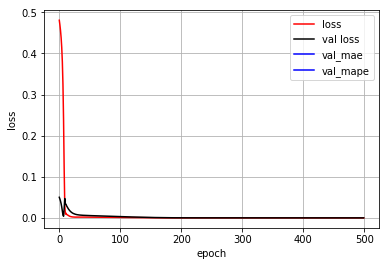

预训练模型学习完毕！
时间粒度 7
处理数据: (339, 2)
训练数据: (230, 11)
验证数据: (98, 11)
LSTM预测
Train on 184 samples, validate on 46 samples
Epoch 1/500
184/184 [==============================] - 7s 40ms/step - loss: 0.3188 - mean_absolute_error: 0.4967 - mean_absolute_percentage_error: 99.7600 - val_loss: 0.0864 - val_mean_absolute_error: 0.2805 - val_mean_absolute_percentage_error: 99.3832
Epoch 2/500
184/184 [==============================] - 0s 565us/step - loss: 0.3173 - mean_absolute_error: 0.4951 - mean_absolute_percentage_error: 99.3131 - val_loss: 0.0855 - val_mean_absolute_error: 0.2790 - val_mean_absolute_percentage_error: 98.7946
Epoch 3/500
184/184 [==============================] - 0s 446us/step - loss: 0.3158 - mean_absolute_error: 0.4936 - mean_absolute_percentage_error: 98.8686 - val_loss: 0.0846 - val_mean_absolute_error: 0.2775 - val_mean_absolute_percentage_error: 98.1981
Epoch 4/500
184/184 [==============================] - 0s 484us/step - loss: 0.3142 - mean_absolute_error: 0.4921 - mean

Epoch 33/500
184/184 [==============================] - 0s 457us/step - loss: 0.2361 - mean_absolute_error: 0.4062 - mean_absolute_percentage_error: 73.7173 - val_loss: 0.0438 - val_mean_absolute_error: 0.1902 - val_mean_absolute_percentage_error: 64.4488
Epoch 34/500
184/184 [==============================] - 0s 554us/step - loss: 0.2307 - mean_absolute_error: 0.3999 - mean_absolute_percentage_error: 71.9506 - val_loss: 0.0415 - val_mean_absolute_error: 0.1842 - val_mean_absolute_percentage_error: 62.1241
Epoch 35/500
184/184 [==============================] - 0s 576us/step - loss: 0.2250 - mean_absolute_error: 0.3931 - mean_absolute_percentage_error: 70.0639 - val_loss: 0.0391 - val_mean_absolute_error: 0.1778 - val_mean_absolute_percentage_error: 59.6412
Epoch 36/500
184/184 [==============================] - 0s 505us/step - loss: 0.2188 - mean_absolute_error: 0.3858 - mean_absolute_percentage_error: 68.1987 - val_loss: 0.0367 - val_mean_absolute_error: 0.1709 - val_mean_absolute_pe

184/184 [==============================] - 0s 380us/step - loss: 0.0168 - mean_absolute_error: 0.1131 - mean_absolute_percentage_error: 43.0382 - val_loss: 0.0208 - val_mean_absolute_error: 0.1295 - val_mean_absolute_percentage_error: 56.9272
Epoch 66/500
184/184 [==============================] - 0s 359us/step - loss: 0.0163 - mean_absolute_error: 0.1116 - mean_absolute_percentage_error: 42.3262 - val_loss: 0.0200 - val_mean_absolute_error: 0.1267 - val_mean_absolute_percentage_error: 55.7884
Epoch 67/500
184/184 [==============================] - 0s 364us/step - loss: 0.0160 - mean_absolute_error: 0.1102 - mean_absolute_percentage_error: 41.6152 - val_loss: 0.0192 - val_mean_absolute_error: 0.1240 - val_mean_absolute_percentage_error: 54.6588
Epoch 68/500
184/184 [==============================] - 0s 359us/step - loss: 0.0156 - mean_absolute_error: 0.1089 - mean_absolute_percentage_error: 40.9531 - val_loss: 0.0185 - val_mean_absolute_error: 0.1214 - val_mean_absolute_percentage_erro

Epoch 129/500
184/184 [==============================] - 0s 370us/step - loss: 0.0037 - mean_absolute_error: 0.0463 - mean_absolute_percentage_error: 19.9665 - val_loss: 0.0057 - val_mean_absolute_error: 0.0656 - val_mean_absolute_percentage_error: 27.4999
Epoch 130/500
184/184 [==============================] - 0s 364us/step - loss: 0.0036 - mean_absolute_error: 0.0458 - mean_absolute_percentage_error: 19.7599 - val_loss: 0.0056 - val_mean_absolute_error: 0.0652 - val_mean_absolute_percentage_error: 27.2555
Epoch 131/500
184/184 [==============================] - 0s 364us/step - loss: 0.0035 - mean_absolute_error: 0.0452 - mean_absolute_percentage_error: 19.5572 - val_loss: 0.0055 - val_mean_absolute_error: 0.0648 - val_mean_absolute_percentage_error: 27.0143
Epoch 132/500
184/184 [==============================] - 0s 370us/step - loss: 0.0035 - mean_absolute_error: 0.0447 - mean_absolute_percentage_error: 19.3586 - val_loss: 0.0055 - val_mean_absolute_error: 0.0644 - val_mean_absolut

Epoch 161/500
184/184 [==============================] - 0s 375us/step - loss: 0.0022 - mean_absolute_error: 0.0357 - mean_absolute_percentage_error: 15.5532 - val_loss: 0.0045 - val_mean_absolute_error: 0.0566 - val_mean_absolute_percentage_error: 21.8456
Epoch 162/500
184/184 [==============================] - 0s 364us/step - loss: 0.0022 - mean_absolute_error: 0.0355 - mean_absolute_percentage_error: 15.4676 - val_loss: 0.0045 - val_mean_absolute_error: 0.0564 - val_mean_absolute_percentage_error: 21.7213
Epoch 163/500
184/184 [==============================] - 0s 370us/step - loss: 0.0022 - mean_absolute_error: 0.0354 - mean_absolute_percentage_error: 15.3836 - val_loss: 0.0045 - val_mean_absolute_error: 0.0563 - val_mean_absolute_percentage_error: 21.6158
Epoch 164/500
184/184 [==============================] - 0s 364us/step - loss: 0.0022 - mean_absolute_error: 0.0352 - mean_absolute_percentage_error: 15.3015 - val_loss: 0.0045 - val_mean_absolute_error: 0.0561 - val_mean_absolut

Epoch 193/500
184/184 [==============================] - 0s 446us/step - loss: 0.0019 - mean_absolute_error: 0.0327 - mean_absolute_percentage_error: 13.7525 - val_loss: 0.0045 - val_mean_absolute_error: 0.0536 - val_mean_absolute_percentage_error: 19.4392
Epoch 194/500
184/184 [==============================] - 0s 495us/step - loss: 0.0018 - mean_absolute_error: 0.0326 - mean_absolute_percentage_error: 13.7212 - val_loss: 0.0045 - val_mean_absolute_error: 0.0535 - val_mean_absolute_percentage_error: 19.3940
Epoch 195/500
184/184 [==============================] - 0s 478us/step - loss: 0.0018 - mean_absolute_error: 0.0326 - mean_absolute_percentage_error: 13.6905 - val_loss: 0.0045 - val_mean_absolute_error: 0.0535 - val_mean_absolute_percentage_error: 19.3496
Epoch 196/500
184/184 [==============================] - 0s 435us/step - loss: 0.0018 - mean_absolute_error: 0.0326 - mean_absolute_percentage_error: 13.6609 - val_loss: 0.0045 - val_mean_absolute_error: 0.0534 - val_mean_absolut

Epoch 225/500
184/184 [==============================] - 0s 457us/step - loss: 0.0018 - mean_absolute_error: 0.0321 - mean_absolute_percentage_error: 13.0530 - val_loss: 0.0047 - val_mean_absolute_error: 0.0524 - val_mean_absolute_percentage_error: 18.3880
Epoch 226/500
184/184 [==============================] - 0s 495us/step - loss: 0.0018 - mean_absolute_error: 0.0321 - mean_absolute_percentage_error: 13.0391 - val_loss: 0.0047 - val_mean_absolute_error: 0.0524 - val_mean_absolute_percentage_error: 18.3659
Epoch 227/500
184/184 [==============================] - 0s 484us/step - loss: 0.0018 - mean_absolute_error: 0.0321 - mean_absolute_percentage_error: 13.0254 - val_loss: 0.0047 - val_mean_absolute_error: 0.0524 - val_mean_absolute_percentage_error: 18.3443
Epoch 228/500
184/184 [==============================] - 0s 495us/step - loss: 0.0018 - mean_absolute_error: 0.0321 - mean_absolute_percentage_error: 13.0121 - val_loss: 0.0047 - val_mean_absolute_error: 0.0524 - val_mean_absolut

Epoch 257/500
184/184 [==============================] - 0s 505us/step - loss: 0.0017 - mean_absolute_error: 0.0320 - mean_absolute_percentage_error: 12.7218 - val_loss: 0.0048 - val_mean_absolute_error: 0.0521 - val_mean_absolute_percentage_error: 17.9832
Epoch 258/500
184/184 [==============================] - 0s 484us/step - loss: 0.0017 - mean_absolute_error: 0.0320 - mean_absolute_percentage_error: 12.7143 - val_loss: 0.0048 - val_mean_absolute_error: 0.0521 - val_mean_absolute_percentage_error: 17.9773
Epoch 259/500
184/184 [==============================] - 0s 489us/step - loss: 0.0017 - mean_absolute_error: 0.0320 - mean_absolute_percentage_error: 12.7068 - val_loss: 0.0048 - val_mean_absolute_error: 0.0521 - val_mean_absolute_percentage_error: 17.9716
Epoch 260/500
184/184 [==============================] - 0s 473us/step - loss: 0.0017 - mean_absolute_error: 0.0320 - mean_absolute_percentage_error: 12.6995 - val_loss: 0.0048 - val_mean_absolute_error: 0.0521 - val_mean_absolut

Epoch 289/500
184/184 [==============================] - 0s 516us/step - loss: 0.0017 - mean_absolute_error: 0.0318 - mean_absolute_percentage_error: 12.5214 - val_loss: 0.0048 - val_mean_absolute_error: 0.0520 - val_mean_absolute_percentage_error: 17.8392
Epoch 290/500
184/184 [==============================] - 0s 457us/step - loss: 0.0017 - mean_absolute_error: 0.0317 - mean_absolute_percentage_error: 12.5161 - val_loss: 0.0048 - val_mean_absolute_error: 0.0520 - val_mean_absolute_percentage_error: 17.8357
Epoch 291/500
184/184 [==============================] - 0s 457us/step - loss: 0.0017 - mean_absolute_error: 0.0317 - mean_absolute_percentage_error: 12.5108 - val_loss: 0.0048 - val_mean_absolute_error: 0.0520 - val_mean_absolute_percentage_error: 17.8323
Epoch 292/500
184/184 [==============================] - 0s 489us/step - loss: 0.0017 - mean_absolute_error: 0.0317 - mean_absolute_percentage_error: 12.5055 - val_loss: 0.0048 - val_mean_absolute_error: 0.0520 - val_mean_absolut

Epoch 321/500
184/184 [==============================] - 0s 462us/step - loss: 0.0017 - mean_absolute_error: 0.0314 - mean_absolute_percentage_error: 12.3618 - val_loss: 0.0048 - val_mean_absolute_error: 0.0519 - val_mean_absolute_percentage_error: 17.7430
Epoch 322/500
184/184 [==============================] - 0s 527us/step - loss: 0.0017 - mean_absolute_error: 0.0314 - mean_absolute_percentage_error: 12.3570 - val_loss: 0.0048 - val_mean_absolute_error: 0.0519 - val_mean_absolute_percentage_error: 17.7404
Epoch 323/500
184/184 [==============================] - 0s 462us/step - loss: 0.0017 - mean_absolute_error: 0.0314 - mean_absolute_percentage_error: 12.3523 - val_loss: 0.0048 - val_mean_absolute_error: 0.0519 - val_mean_absolute_percentage_error: 17.7377
Epoch 324/500
184/184 [==============================] - 0s 446us/step - loss: 0.0017 - mean_absolute_error: 0.0314 - mean_absolute_percentage_error: 12.3476 - val_loss: 0.0048 - val_mean_absolute_error: 0.0519 - val_mean_absolut

Epoch 353/500
184/184 [==============================] - 0s 435us/step - loss: 0.0017 - mean_absolute_error: 0.0311 - mean_absolute_percentage_error: 12.2109 - val_loss: 0.0048 - val_mean_absolute_error: 0.0518 - val_mean_absolute_percentage_error: 17.6644
Epoch 354/500
184/184 [==============================] - 0s 446us/step - loss: 0.0017 - mean_absolute_error: 0.0311 - mean_absolute_percentage_error: 12.2061 - val_loss: 0.0048 - val_mean_absolute_error: 0.0518 - val_mean_absolute_percentage_error: 17.6621
Epoch 355/500
184/184 [==============================] - 0s 457us/step - loss: 0.0017 - mean_absolute_error: 0.0311 - mean_absolute_percentage_error: 12.2014 - val_loss: 0.0048 - val_mean_absolute_error: 0.0518 - val_mean_absolute_percentage_error: 17.6598
Epoch 356/500
184/184 [==============================] - 0s 516us/step - loss: 0.0017 - mean_absolute_error: 0.0310 - mean_absolute_percentage_error: 12.1966 - val_loss: 0.0048 - val_mean_absolute_error: 0.0518 - val_mean_absolut

Epoch 385/500
184/184 [==============================] - 0s 549us/step - loss: 0.0016 - mean_absolute_error: 0.0307 - mean_absolute_percentage_error: 12.0569 - val_loss: 0.0048 - val_mean_absolute_error: 0.0517 - val_mean_absolute_percentage_error: 17.5903
Epoch 386/500
184/184 [==============================] - 0s 522us/step - loss: 0.0016 - mean_absolute_error: 0.0307 - mean_absolute_percentage_error: 12.0521 - val_loss: 0.0048 - val_mean_absolute_error: 0.0517 - val_mean_absolute_percentage_error: 17.5879
Epoch 387/500
184/184 [==============================] - 0s 467us/step - loss: 0.0016 - mean_absolute_error: 0.0307 - mean_absolute_percentage_error: 12.0472 - val_loss: 0.0048 - val_mean_absolute_error: 0.0517 - val_mean_absolute_percentage_error: 17.5856
Epoch 388/500
184/184 [==============================] - 0s 473us/step - loss: 0.0016 - mean_absolute_error: 0.0307 - mean_absolute_percentage_error: 12.0423 - val_loss: 0.0048 - val_mean_absolute_error: 0.0517 - val_mean_absolut

Epoch 417/500
184/184 [==============================] - 0s 451us/step - loss: 0.0016 - mean_absolute_error: 0.0303 - mean_absolute_percentage_error: 11.8973 - val_loss: 0.0048 - val_mean_absolute_error: 0.0516 - val_mean_absolute_percentage_error: 17.5123
Epoch 418/500
184/184 [==============================] - 0s 473us/step - loss: 0.0016 - mean_absolute_error: 0.0303 - mean_absolute_percentage_error: 11.8922 - val_loss: 0.0048 - val_mean_absolute_error: 0.0516 - val_mean_absolute_percentage_error: 17.5098
Epoch 419/500
184/184 [==============================] - 0s 478us/step - loss: 0.0016 - mean_absolute_error: 0.0303 - mean_absolute_percentage_error: 11.8871 - val_loss: 0.0047 - val_mean_absolute_error: 0.0515 - val_mean_absolute_percentage_error: 17.5073
Epoch 420/500
184/184 [==============================] - 0s 533us/step - loss: 0.0016 - mean_absolute_error: 0.0303 - mean_absolute_percentage_error: 11.8820 - val_loss: 0.0047 - val_mean_absolute_error: 0.0515 - val_mean_absolut

Epoch 449/500
184/184 [==============================] - 0s 484us/step - loss: 0.0016 - mean_absolute_error: 0.0299 - mean_absolute_percentage_error: 11.7323 - val_loss: 0.0047 - val_mean_absolute_error: 0.0514 - val_mean_absolute_percentage_error: 17.4292
Epoch 450/500
184/184 [==============================] - 0s 419us/step - loss: 0.0016 - mean_absolute_error: 0.0299 - mean_absolute_percentage_error: 11.7272 - val_loss: 0.0047 - val_mean_absolute_error: 0.0514 - val_mean_absolute_percentage_error: 17.4266
Epoch 451/500
184/184 [==============================] - 0s 462us/step - loss: 0.0016 - mean_absolute_error: 0.0299 - mean_absolute_percentage_error: 11.7220 - val_loss: 0.0047 - val_mean_absolute_error: 0.0514 - val_mean_absolute_percentage_error: 17.4239
Epoch 452/500
184/184 [==============================] - 0s 630us/step - loss: 0.0016 - mean_absolute_error: 0.0298 - mean_absolute_percentage_error: 11.7168 - val_loss: 0.0047 - val_mean_absolute_error: 0.0514 - val_mean_absolut

Epoch 481/500
184/184 [==============================] - 0s 473us/step - loss: 0.0015 - mean_absolute_error: 0.0295 - mean_absolute_percentage_error: 11.5659 - val_loss: 0.0047 - val_mean_absolute_error: 0.0512 - val_mean_absolute_percentage_error: 17.3408
Epoch 482/500
184/184 [==============================] - 0s 419us/step - loss: 0.0015 - mean_absolute_error: 0.0295 - mean_absolute_percentage_error: 11.5606 - val_loss: 0.0047 - val_mean_absolute_error: 0.0512 - val_mean_absolute_percentage_error: 17.3379
Epoch 483/500
184/184 [==============================] - 0s 576us/step - loss: 0.0015 - mean_absolute_error: 0.0295 - mean_absolute_percentage_error: 11.5553 - val_loss: 0.0047 - val_mean_absolute_error: 0.0512 - val_mean_absolute_percentage_error: 17.3350
Epoch 484/500
184/184 [==============================] - 0s 489us/step - loss: 0.0015 - mean_absolute_error: 0.0294 - mean_absolute_percentage_error: 11.5500 - val_loss: 0.0047 - val_mean_absolute_error: 0.0512 - val_mean_absolut

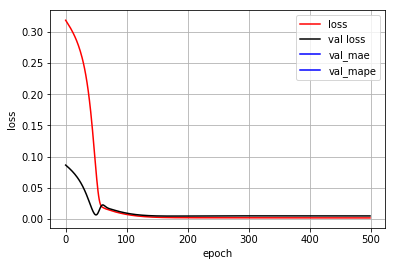

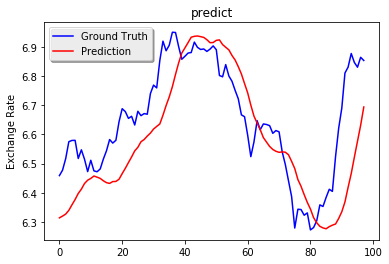

RMSE:0.15173920796793453  ,MAE:0.12087947481116465  ,MAPE:1.8125083295755882 
迁移学习微调
微调迁移学习模型
Train on 161 samples, validate on 69 samples
Epoch 1/50
161/161 [==============================] - 5s 32ms/step - loss: 0.3058 - mean_absolute_error: 0.4718 - mean_absolute_percentage_error: 80.3946 - val_loss: 0.0283 - val_mean_absolute_error: 0.1516 - val_mean_absolute_percentage_error: 55.2250
Epoch 2/50
161/161 [==============================] - 0s 950us/step - loss: 0.0999 - mean_absolute_error: 0.2407 - mean_absolute_percentage_error: 36.0933 - val_loss: 0.0035 - val_mean_absolute_error: 0.0459 - val_mean_absolute_percentage_error: 19.4010
Epoch 3/50
161/161 [==============================] - 0s 963us/step - loss: 0.0093 - mean_absolute_error: 0.0863 - mean_absolute_percentage_error: 21.4857 - val_loss: 0.0049 - val_mean_absolute_error: 0.0600 - val_mean_absolute_percentage_error: 29.5847
Epoch 4/50
161/161 [==============================] - 0s 820us/step - loss: 0.0042 - mean_absolute_e

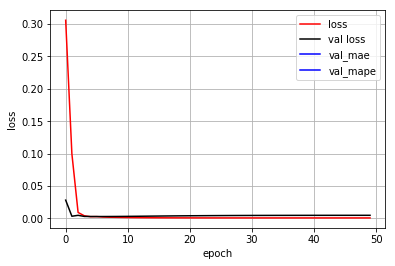

迁移学习LSTM预测


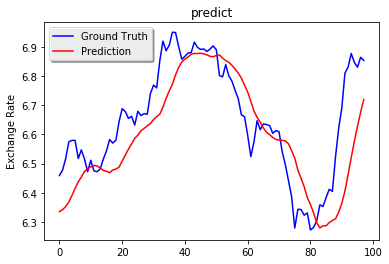

RMSE:0.13252280345771844  ,MAE:0.10143340995944275  ,MAPE:1.5242220978673333 


In [10]:
# 直接预测与时间粒度迁移学习预测
saveFile = r'D:\WORK__wells\GraduateProgram\Model\PreModel_Daily_Data_'+ fileName +'.h5'
PrepareModel = PrePareLSTM(preTrained_pd, params)
PrepareModel.save(saveFile)
# PrepareModel = load_model(saveFile)
result_pd = TransferLearning(ExgRate_pd, PrepareModel,params,fileName, fileName)

时间粒度 7
处理数据: (339, 2)
训练数据: (230, 11)
验证数据: (98, 11)
LSTM预测
Train on 184 samples, validate on 46 samples
Epoch 1/500
184/184 [==============================] - 9s 47ms/step - loss: 0.3188 - mean_absolute_error: 0.4967 - mean_absolute_percentage_error: 99.7519 - val_loss: 0.0863 - val_mean_absolute_error: 0.2805 - val_mean_absolute_percentage_error: 99.3617
Epoch 2/500
184/184 [==============================] - 0s 462us/step - loss: 0.3172 - mean_absolute_error: 0.4951 - mean_absolute_percentage_error: 99.2891 - val_loss: 0.0854 - val_mean_absolute_error: 0.2789 - val_mean_absolute_percentage_error: 98.7501
Epoch 3/500
184/184 [==============================] - 0s 473us/step - loss: 0.3156 - mean_absolute_error: 0.4935 - mean_absolute_percentage_error: 98.8270 - val_loss: 0.0846 - val_mean_absolute_error: 0.2773 - val_mean_absolute_percentage_error: 98.1319
Epoch 4/500
184/184 [==============================] - 0s 544us/step - loss: 0.3140 - mean_absolute_error: 0.4919 - mean_absolute_p

Epoch 33/500
184/184 [==============================] - 0s 429us/step - loss: 0.2351 - mean_absolute_error: 0.4048 - mean_absolute_percentage_error: 73.2370 - val_loss: 0.0431 - val_mean_absolute_error: 0.1885 - val_mean_absolute_percentage_error: 63.7552
Epoch 34/500
184/184 [==============================] - 0s 511us/step - loss: 0.2298 - mean_absolute_error: 0.3985 - mean_absolute_percentage_error: 71.4761 - val_loss: 0.0408 - val_mean_absolute_error: 0.1824 - val_mean_absolute_percentage_error: 61.4292
Epoch 35/500
184/184 [==============================] - 0s 473us/step - loss: 0.2241 - mean_absolute_error: 0.3917 - mean_absolute_percentage_error: 69.6315 - val_loss: 0.0385 - val_mean_absolute_error: 0.1760 - val_mean_absolute_percentage_error: 58.9489
Epoch 36/500
184/184 [==============================] - 0s 446us/step - loss: 0.2181 - mean_absolute_error: 0.3846 - mean_absolute_percentage_error: 67.8115 - val_loss: 0.0361 - val_mean_absolute_error: 0.1691 - val_mean_absolute_pe

184/184 [==============================] - 0s 429us/step - loss: 0.0173 - mean_absolute_error: 0.1147 - mean_absolute_percentage_error: 43.8429 - val_loss: 0.0218 - val_mean_absolute_error: 0.1330 - val_mean_absolute_percentage_error: 58.3691
Epoch 66/500
184/184 [==============================] - 0s 446us/step - loss: 0.0168 - mean_absolute_error: 0.1130 - mean_absolute_percentage_error: 43.1296 - val_loss: 0.0210 - val_mean_absolute_error: 0.1301 - val_mean_absolute_percentage_error: 57.2089
Epoch 67/500
184/184 [==============================] - 0s 495us/step - loss: 0.0164 - mean_absolute_error: 0.1116 - mean_absolute_percentage_error: 42.4075 - val_loss: 0.0202 - val_mean_absolute_error: 0.1273 - val_mean_absolute_percentage_error: 56.0522
Epoch 68/500
184/184 [==============================] - 0s 446us/step - loss: 0.0161 - mean_absolute_error: 0.1103 - mean_absolute_percentage_error: 41.7174 - val_loss: 0.0194 - val_mean_absolute_error: 0.1246 - val_mean_absolute_percentage_erro

Epoch 129/500
184/184 [==============================] - 0s 435us/step - loss: 0.0036 - mean_absolute_error: 0.0454 - mean_absolute_percentage_error: 19.8949 - val_loss: 0.0056 - val_mean_absolute_error: 0.0657 - val_mean_absolute_percentage_error: 27.5485
Epoch 130/500
184/184 [==============================] - 0s 446us/step - loss: 0.0035 - mean_absolute_error: 0.0449 - mean_absolute_percentage_error: 19.6867 - val_loss: 0.0055 - val_mean_absolute_error: 0.0652 - val_mean_absolute_percentage_error: 27.2860
Epoch 131/500
184/184 [==============================] - 0s 435us/step - loss: 0.0035 - mean_absolute_error: 0.0444 - mean_absolute_percentage_error: 19.4837 - val_loss: 0.0055 - val_mean_absolute_error: 0.0648 - val_mean_absolute_percentage_error: 27.0330
Epoch 132/500
184/184 [==============================] - 0s 462us/step - loss: 0.0034 - mean_absolute_error: 0.0439 - mean_absolute_percentage_error: 19.2870 - val_loss: 0.0054 - val_mean_absolute_error: 0.0643 - val_mean_absolut

Epoch 161/500
184/184 [==============================] - 0s 457us/step - loss: 0.0022 - mean_absolute_error: 0.0353 - mean_absolute_percentage_error: 15.5346 - val_loss: 0.0045 - val_mean_absolute_error: 0.0564 - val_mean_absolute_percentage_error: 21.8045
Epoch 162/500
184/184 [==============================] - 0s 440us/step - loss: 0.0022 - mean_absolute_error: 0.0351 - mean_absolute_percentage_error: 15.4524 - val_loss: 0.0044 - val_mean_absolute_error: 0.0562 - val_mean_absolute_percentage_error: 21.6775
Epoch 163/500
184/184 [==============================] - 0s 435us/step - loss: 0.0022 - mean_absolute_error: 0.0350 - mean_absolute_percentage_error: 15.3721 - val_loss: 0.0044 - val_mean_absolute_error: 0.0560 - val_mean_absolute_percentage_error: 21.5528
Epoch 164/500
184/184 [==============================] - 0s 484us/step - loss: 0.0022 - mean_absolute_error: 0.0348 - mean_absolute_percentage_error: 15.2948 - val_loss: 0.0044 - val_mean_absolute_error: 0.0558 - val_mean_absolut

Epoch 193/500
184/184 [==============================] - 0s 467us/step - loss: 0.0019 - mean_absolute_error: 0.0329 - mean_absolute_percentage_error: 13.8973 - val_loss: 0.0044 - val_mean_absolute_error: 0.0530 - val_mean_absolute_percentage_error: 19.2913
Epoch 194/500
184/184 [==============================] - 0s 549us/step - loss: 0.0019 - mean_absolute_error: 0.0329 - mean_absolute_percentage_error: 13.8694 - val_loss: 0.0044 - val_mean_absolute_error: 0.0530 - val_mean_absolute_percentage_error: 19.2480
Epoch 195/500
184/184 [==============================] - 0s 484us/step - loss: 0.0019 - mean_absolute_error: 0.0329 - mean_absolute_percentage_error: 13.8421 - val_loss: 0.0044 - val_mean_absolute_error: 0.0529 - val_mean_absolute_percentage_error: 19.2057
Epoch 196/500
184/184 [==============================] - 0s 516us/step - loss: 0.0019 - mean_absolute_error: 0.0329 - mean_absolute_percentage_error: 13.8153 - val_loss: 0.0044 - val_mean_absolute_error: 0.0529 - val_mean_absolut

Epoch 225/500
184/184 [==============================] - 0s 473us/step - loss: 0.0018 - mean_absolute_error: 0.0327 - mean_absolute_percentage_error: 13.2713 - val_loss: 0.0045 - val_mean_absolute_error: 0.0519 - val_mean_absolute_percentage_error: 18.2968
Epoch 226/500
184/184 [==============================] - 0s 462us/step - loss: 0.0018 - mean_absolute_error: 0.0327 - mean_absolute_percentage_error: 13.2590 - val_loss: 0.0045 - val_mean_absolute_error: 0.0519 - val_mean_absolute_percentage_error: 18.2761
Epoch 227/500
184/184 [==============================] - 0s 495us/step - loss: 0.0018 - mean_absolute_error: 0.0327 - mean_absolute_percentage_error: 13.2471 - val_loss: 0.0045 - val_mean_absolute_error: 0.0519 - val_mean_absolute_percentage_error: 18.2559
Epoch 228/500
184/184 [==============================] - 0s 511us/step - loss: 0.0018 - mean_absolute_error: 0.0327 - mean_absolute_percentage_error: 13.2353 - val_loss: 0.0045 - val_mean_absolute_error: 0.0519 - val_mean_absolut

Epoch 257/500
184/184 [==============================] - 0s 500us/step - loss: 0.0018 - mean_absolute_error: 0.0327 - mean_absolute_percentage_error: 12.9740 - val_loss: 0.0046 - val_mean_absolute_error: 0.0514 - val_mean_absolute_percentage_error: 17.8379
Epoch 258/500
184/184 [==============================] - 0s 451us/step - loss: 0.0018 - mean_absolute_error: 0.0327 - mean_absolute_percentage_error: 12.9668 - val_loss: 0.0046 - val_mean_absolute_error: 0.0514 - val_mean_absolute_percentage_error: 17.8301
Epoch 259/500
184/184 [==============================] - 0s 451us/step - loss: 0.0018 - mean_absolute_error: 0.0327 - mean_absolute_percentage_error: 12.9596 - val_loss: 0.0046 - val_mean_absolute_error: 0.0514 - val_mean_absolute_percentage_error: 17.8225
Epoch 260/500
184/184 [==============================] - 0s 440us/step - loss: 0.0018 - mean_absolute_error: 0.0327 - mean_absolute_percentage_error: 12.9526 - val_loss: 0.0046 - val_mean_absolute_error: 0.0514 - val_mean_absolut

Epoch 289/500
184/184 [==============================] - 0s 522us/step - loss: 0.0018 - mean_absolute_error: 0.0325 - mean_absolute_percentage_error: 12.7712 - val_loss: 0.0046 - val_mean_absolute_error: 0.0513 - val_mean_absolute_percentage_error: 17.6872
Epoch 290/500
184/184 [==============================] - 0s 467us/step - loss: 0.0018 - mean_absolute_error: 0.0324 - mean_absolute_percentage_error: 12.7654 - val_loss: 0.0046 - val_mean_absolute_error: 0.0513 - val_mean_absolute_percentage_error: 17.6836
Epoch 291/500
184/184 [==============================] - 0s 462us/step - loss: 0.0018 - mean_absolute_error: 0.0324 - mean_absolute_percentage_error: 12.7598 - val_loss: 0.0046 - val_mean_absolute_error: 0.0513 - val_mean_absolute_percentage_error: 17.6801
Epoch 292/500
184/184 [==============================] - 0s 429us/step - loss: 0.0018 - mean_absolute_error: 0.0324 - mean_absolute_percentage_error: 12.7541 - val_loss: 0.0046 - val_mean_absolute_error: 0.0513 - val_mean_absolut

Epoch 321/500
184/184 [==============================] - 0s 419us/step - loss: 0.0017 - mean_absolute_error: 0.0321 - mean_absolute_percentage_error: 12.5957 - val_loss: 0.0046 - val_mean_absolute_error: 0.0512 - val_mean_absolute_percentage_error: 17.5859
Epoch 322/500
184/184 [==============================] - 0s 484us/step - loss: 0.0017 - mean_absolute_error: 0.0321 - mean_absolute_percentage_error: 12.5904 - val_loss: 0.0046 - val_mean_absolute_error: 0.0512 - val_mean_absolute_percentage_error: 17.5830
Epoch 323/500
184/184 [==============================] - 0s 473us/step - loss: 0.0017 - mean_absolute_error: 0.0321 - mean_absolute_percentage_error: 12.5850 - val_loss: 0.0046 - val_mean_absolute_error: 0.0512 - val_mean_absolute_percentage_error: 17.5801
Epoch 324/500
184/184 [==============================] - 0s 446us/step - loss: 0.0017 - mean_absolute_error: 0.0320 - mean_absolute_percentage_error: 12.5797 - val_loss: 0.0046 - val_mean_absolute_error: 0.0512 - val_mean_absolut

Epoch 353/500
184/184 [==============================] - 0s 413us/step - loss: 0.0017 - mean_absolute_error: 0.0316 - mean_absolute_percentage_error: 12.4245 - val_loss: 0.0046 - val_mean_absolute_error: 0.0510 - val_mean_absolute_percentage_error: 17.4989
Epoch 354/500
184/184 [==============================] - 0s 478us/step - loss: 0.0017 - mean_absolute_error: 0.0316 - mean_absolute_percentage_error: 12.4191 - val_loss: 0.0046 - val_mean_absolute_error: 0.0510 - val_mean_absolute_percentage_error: 17.4964
Epoch 355/500
184/184 [==============================] - 0s 505us/step - loss: 0.0017 - mean_absolute_error: 0.0316 - mean_absolute_percentage_error: 12.4137 - val_loss: 0.0046 - val_mean_absolute_error: 0.0510 - val_mean_absolute_percentage_error: 17.4938
Epoch 356/500
184/184 [==============================] - 0s 462us/step - loss: 0.0017 - mean_absolute_error: 0.0316 - mean_absolute_percentage_error: 12.4082 - val_loss: 0.0046 - val_mean_absolute_error: 0.0510 - val_mean_absolut

Epoch 385/500
184/184 [==============================] - 0s 440us/step - loss: 0.0017 - mean_absolute_error: 0.0312 - mean_absolute_percentage_error: 12.2476 - val_loss: 0.0046 - val_mean_absolute_error: 0.0509 - val_mean_absolute_percentage_error: 17.4154
Epoch 386/500
184/184 [==============================] - 0s 495us/step - loss: 0.0017 - mean_absolute_error: 0.0311 - mean_absolute_percentage_error: 12.2420 - val_loss: 0.0046 - val_mean_absolute_error: 0.0509 - val_mean_absolute_percentage_error: 17.4127
Epoch 387/500
184/184 [==============================] - 0s 451us/step - loss: 0.0017 - mean_absolute_error: 0.0311 - mean_absolute_percentage_error: 12.2363 - val_loss: 0.0046 - val_mean_absolute_error: 0.0509 - val_mean_absolute_percentage_error: 17.4100
Epoch 388/500
184/184 [==============================] - 0s 484us/step - loss: 0.0016 - mean_absolute_error: 0.0311 - mean_absolute_percentage_error: 12.2307 - val_loss: 0.0046 - val_mean_absolute_error: 0.0509 - val_mean_absolut

Epoch 417/500
184/184 [==============================] - 0s 500us/step - loss: 0.0016 - mean_absolute_error: 0.0307 - mean_absolute_percentage_error: 12.0632 - val_loss: 0.0046 - val_mean_absolute_error: 0.0507 - val_mean_absolute_percentage_error: 17.3270
Epoch 418/500
184/184 [==============================] - 0s 478us/step - loss: 0.0016 - mean_absolute_error: 0.0306 - mean_absolute_percentage_error: 12.0573 - val_loss: 0.0046 - val_mean_absolute_error: 0.0507 - val_mean_absolute_percentage_error: 17.3242
Epoch 419/500
184/184 [==============================] - 0s 457us/step - loss: 0.0016 - mean_absolute_error: 0.0306 - mean_absolute_percentage_error: 12.0514 - val_loss: 0.0046 - val_mean_absolute_error: 0.0507 - val_mean_absolute_percentage_error: 17.3213
Epoch 420/500
184/184 [==============================] - 0s 587us/step - loss: 0.0016 - mean_absolute_error: 0.0306 - mean_absolute_percentage_error: 12.0455 - val_loss: 0.0046 - val_mean_absolute_error: 0.0507 - val_mean_absolut

Epoch 449/500
184/184 [==============================] - 0s 560us/step - loss: 0.0016 - mean_absolute_error: 0.0301 - mean_absolute_percentage_error: 11.8714 - val_loss: 0.0045 - val_mean_absolute_error: 0.0506 - val_mean_absolute_percentage_error: 17.2331
Epoch 450/500
184/184 [==============================] - 0s 467us/step - loss: 0.0016 - mean_absolute_error: 0.0301 - mean_absolute_percentage_error: 11.8654 - val_loss: 0.0045 - val_mean_absolute_error: 0.0506 - val_mean_absolute_percentage_error: 17.2300
Epoch 451/500
184/184 [==============================] - 0s 446us/step - loss: 0.0016 - mean_absolute_error: 0.0301 - mean_absolute_percentage_error: 11.8593 - val_loss: 0.0045 - val_mean_absolute_error: 0.0506 - val_mean_absolute_percentage_error: 17.2270
Epoch 452/500
184/184 [==============================] - 0s 451us/step - loss: 0.0016 - mean_absolute_error: 0.0301 - mean_absolute_percentage_error: 11.8532 - val_loss: 0.0045 - val_mean_absolute_error: 0.0505 - val_mean_absolut

Epoch 481/500
184/184 [==============================] - 0s 582us/step - loss: 0.0015 - mean_absolute_error: 0.0296 - mean_absolute_percentage_error: 11.6741 - val_loss: 0.0045 - val_mean_absolute_error: 0.0504 - val_mean_absolute_percentage_error: 17.1331
Epoch 482/500
184/184 [==============================] - 0s 489us/step - loss: 0.0015 - mean_absolute_error: 0.0296 - mean_absolute_percentage_error: 11.6678 - val_loss: 0.0045 - val_mean_absolute_error: 0.0504 - val_mean_absolute_percentage_error: 17.1299
Epoch 483/500
184/184 [==============================] - 0s 473us/step - loss: 0.0015 - mean_absolute_error: 0.0296 - mean_absolute_percentage_error: 11.6616 - val_loss: 0.0045 - val_mean_absolute_error: 0.0504 - val_mean_absolute_percentage_error: 17.1266
Epoch 484/500
184/184 [==============================] - 0s 495us/step - loss: 0.0015 - mean_absolute_error: 0.0296 - mean_absolute_percentage_error: 11.6553 - val_loss: 0.0045 - val_mean_absolute_error: 0.0504 - val_mean_absolut

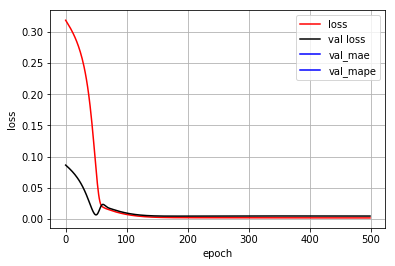

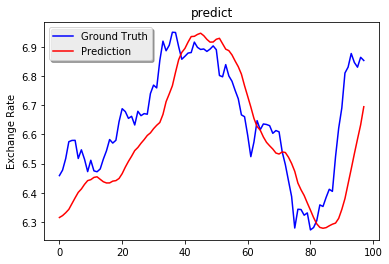

RMSE:0.14836408669791212  ,MAE:0.11893195149947183  ,MAPE:1.7831543393608793 
迁移学习微调
微调迁移学习模型
Train on 161 samples, validate on 69 samples
Epoch 1/50
161/161 [==============================] - 5s 33ms/step - loss: 0.2358 - mean_absolute_error: 0.4119 - mean_absolute_percentage_error: 69.4871 - val_loss: 0.0183 - val_mean_absolute_error: 0.1212 - val_mean_absolute_percentage_error: 43.9783
Epoch 2/50
161/161 [==============================] - 0s 783us/step - loss: 0.0790 - mean_absolute_error: 0.2191 - mean_absolute_percentage_error: 33.2648 - val_loss: 0.0020 - val_mean_absolute_error: 0.0310 - val_mean_absolute_percentage_error: 12.9819
Epoch 3/50
161/161 [==============================] - 0s 770us/step - loss: 0.0113 - mean_absolute_error: 0.0837 - mean_absolute_percentage_error: 16.9961 - val_loss: 0.0035 - val_mean_absolute_error: 0.0533 - val_mean_absolute_percentage_error: 25.7755
Epoch 4/50
161/161 [==============================] - 0s 677us/step - loss: 0.0025 - mean_absolute_e

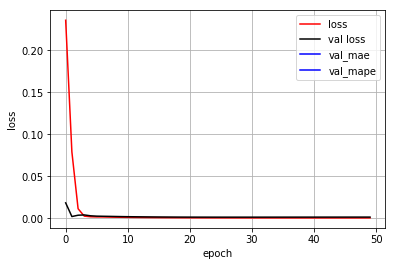

迁移学习LSTM预测


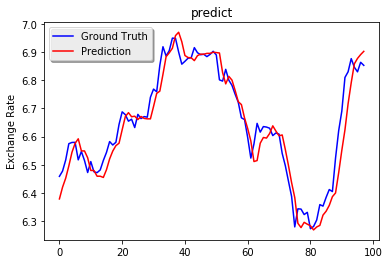

RMSE:0.05631759118688931  ,MAE:0.04232831239505686  ,MAPE:0.638778509014856 


In [11]:
# 货币对迁移学习与直接预测
saveFile = r'D:\WORK__wells\GraduateProgram\Model\PreModel_Daily_Data_'+ fileName2 +'.h5'
PrepareModel = load_model(saveFile)
# PrepareModel = PrePareLSTM(preTrained_pd, params)
# PrepareModel.save(saveFile)
result_pd = TransferLearning(ExgRate_pd, PrepareModel,params,fileName, fileName2)

In [ ]:
# params = {
#           'Timescale':[7],
#           'lr': 0.001,
#           'nb_hidden_cell': [80,80,80,80,80],
#           'epochs': 500,
#           'batch_size': 200,
#           'TimeLag': 10,
#           'TrainTestSplit':0.7,
          
#           'TransferEpochs':50,
#           'TransferBatch_size':10,
#           'frozenlayer':3,
#         }

# rootdir = r'D:\WORK__wells\GraduateProgram\Data\DailyData'
# pathContainer,filenameContainer = walkfiles(rootdir)


# fileIndex = [0,1]
# # 0为澳元 1为欧元 5为CNY

# ExgRate_pd ,fileName= get_data(0,pathContainer,filenameContainer)
# for j in fileIndex:
#     if j!= 0:
#         ExgRate2_pd ,fileName2= get_data(j,pathContainer,filenameContainer)
        
#         preTrained_pd,data_pd = data_split(ExgRate2_pd)
    
#         saveFile = r'D:\WORK__wells\GraduateProgram\Model\PreModel_Daily_Data_'+ fileName +'.h5'
#         PrepareModel = load_model(saveFile)
# #     PrepareModel = PrePareLSTM(preTrained_pd, params)
# #     PrepareModel.save(saveFile)
    
#         result_pd = TransferLearning(data_pd, PrepareModel,params,fileName, fileName2)